
Found 5 run files in ./results/sasgld/sasgld_gaussian_scale1.0_lr0.01_H1200_bs100_m0.1_M10.0_alpha100.0_r0.25_s2.0

Valid runs: 5/5

=== Aggregated Predictive Metrics (mean ± CI) ===
ACC       : 0.9029 ± 0.0015
NLL       : 4.1501 ± 0.0065
ECE       : 0.8847 ± 0.0014
BRIER     : 0.9653 ± 0.0002


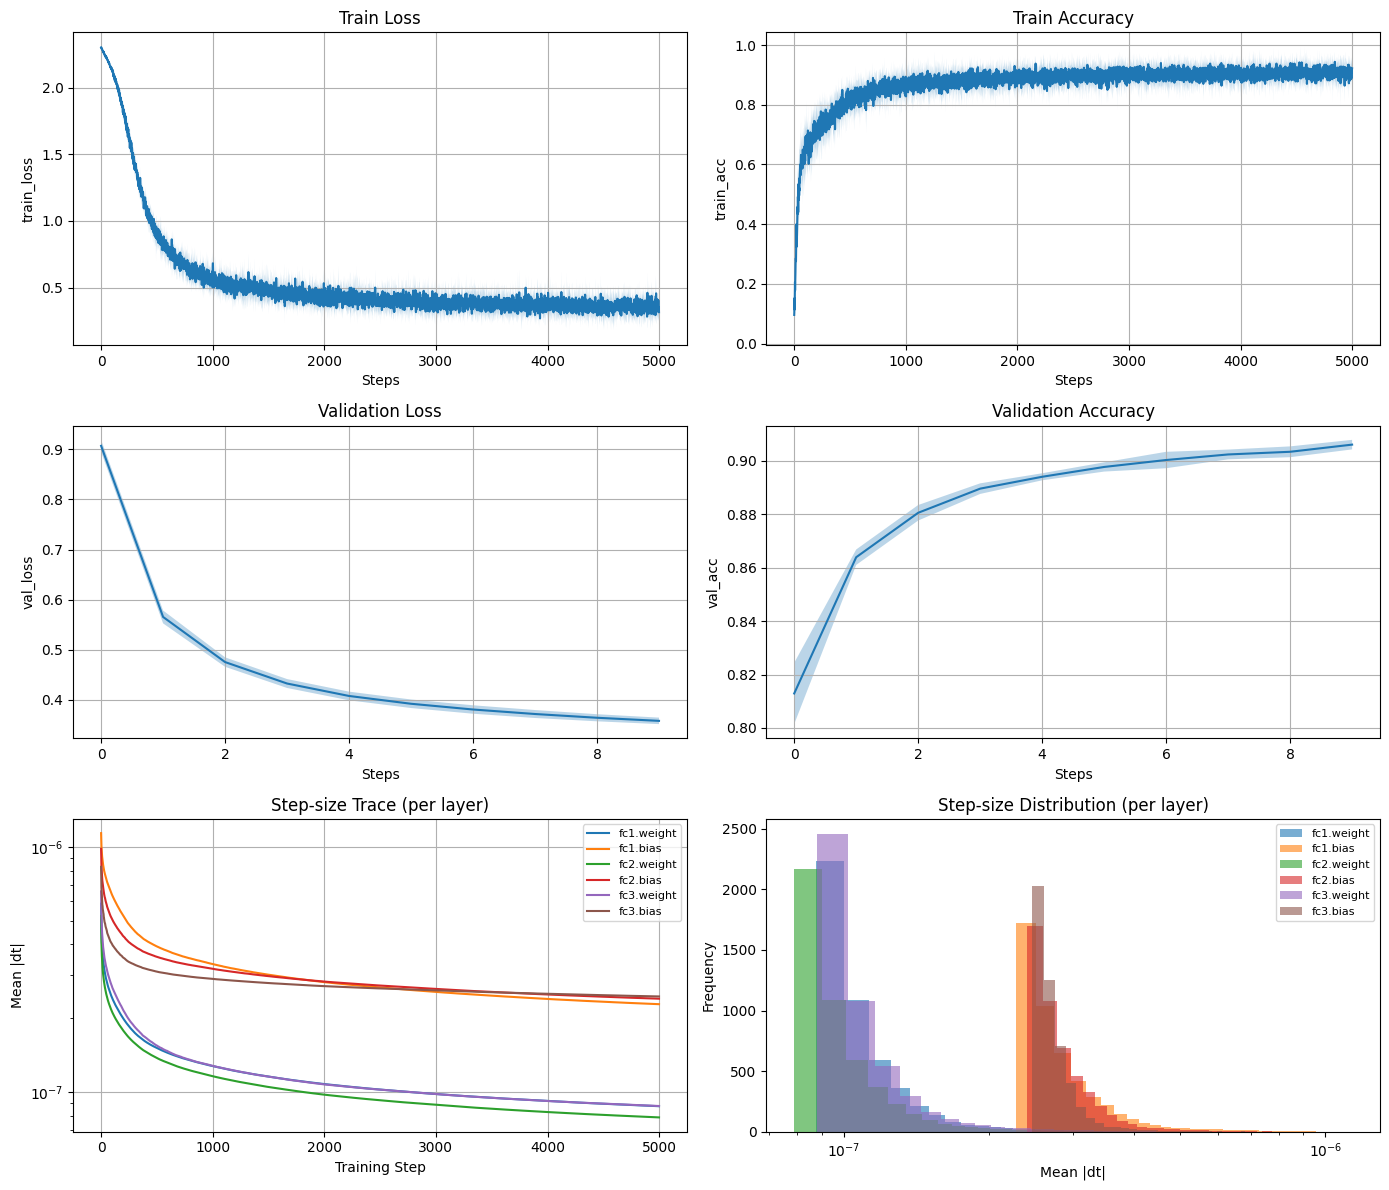

In [1]:
# Analysis Script: Training Curves + Step-size Traces
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from utils import mean_confidence_interval

# ------------------------
# Config
# ------------------------
results_dir = "./results"
confidence = 0.95

# Option 1: Specify experiment folder path directly
experiment_folder = "./results/sasgld/sasgld_gaussian_scale1.0_lr0.01_H1200_bs100_m0.1_M10.0_alpha100.0_r0.25_s2.0" # ./results/sasgld/sasgld_laplace_scale1.0_lr0.02_H1200_bs100"
# Option 2: Set to None to manually select from available experiments
# experiment_folder = None

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------
# Find and select experiment
# ------------------------
if experiment_folder is None:
    # Auto-discover available experiments
    available_experiments = []
    for sampler in os.listdir(results_dir):
        sampler_path = os.path.join(results_dir, sampler)
        if os.path.isdir(sampler_path) and not sampler.startswith('.'):
            for exp in os.listdir(sampler_path):
                exp_path = os.path.join(sampler_path, exp)
                if os.path.isdir(exp_path):
                    available_experiments.append(exp_path)

    if len(available_experiments) == 0:
        raise ValueError(f"No experiment folders found in {results_dir}")

    print("Available experiments:")
    for i, exp in enumerate(available_experiments):
        print(f"  [{i}] {exp}")

    experiment_folder = available_experiments[0]
    print(f"\nUsing: {experiment_folder}")
else:
    if not os.path.exists(experiment_folder):
        raise ValueError(f"Experiment folder not found: {experiment_folder}")

# ------------------------
# Load runs
# ------------------------
run_paths = sorted(glob(os.path.join(experiment_folder, "*.pt")))
run_paths = [p for p in run_paths if not p.endswith('manifest.json')]

if len(run_paths) == 0:
    raise ValueError(f"No .pt files found in {experiment_folder}")

print(f"\nFound {len(run_paths)} run files in {experiment_folder}")
runs = [torch.load(p, map_location="cpu", weights_only=False) for p in run_paths]

# ------------------------
# Load experiment config from manifest if available
# ------------------------
manifest_path = os.path.join(experiment_folder, "manifest.json")
if os.path.exists(manifest_path):
    with open(manifest_path, 'r') as f:
        manifest = json.load(f)
        exp_config = manifest.get("config", {})
        print(f"\nExperiment config:")
        for k, v in exp_config.items():
            if k not in ["device", "results_dir"]:
                print(f"  {k}: {v}")

# ------------------------
# Filter valid runs with test metrics
# ------------------------
valid_runs = [r for r in runs if r.get("test_metrics") and len(r.get("test_metrics", {})) > 0]
print(f"\nValid runs: {len(valid_runs)}/{len(runs)}")

# ------------------------
# Aggregate predictive metrics
# ------------------------
metric_keys = ["acc", "nll", "ece", "brier"]
agg_metrics = {}

if len(valid_runs) == 0:
    print("❌ No valid runs with test metrics found.")
else:
    print("\n=== Aggregated Predictive Metrics (mean ± CI) ===")
    for k in metric_keys:
        vals = [r["test_metrics"].get(k, np.nan) for r in valid_runs]
        vals = [v for v in vals if not np.isnan(v)]

        if len(vals) > 0:
            mean = np.mean(vals)
            if len(vals) > 1:
                _, ci = mean_confidence_interval(vals, confidence)
                print(f"{k.upper():<10}: {mean:.4f} ± {ci:.4f}")
                agg_metrics[k] = {"mean": float(mean), "ci": float(ci)}
            else:
                print(f"{k.upper():<10}: {mean:.4f} (single run)")
                agg_metrics[k] = {"mean": float(mean), "ci": 0.0}
        else:
            print(f"{k.upper():<10}: No valid values found")

# ------------------------
# Aggregate training curves
# ------------------------
history_keys = ["train_loss", "train_acc", "val_loss", "val_acc"]
agg_curves = {}

if len(valid_runs) > 0:
    for key in history_keys:
        min_len = min(len(r["train_val_history"][key]) for r in valid_runs)
        aligned = np.array([r["train_val_history"][key][:min_len] for r in valid_runs])

        if len(valid_runs) > 1:
            mean, ci = mean_confidence_interval(aligned, confidence)
        else:
            mean = aligned[0]
            ci = np.zeros_like(mean)

        agg_curves[key] = {"mean": mean, "ci": ci}

# ------------------------
# Step-size traces per layer (single run)
# ------------------------
run_idx = 0  # first run
dt_hist = runs[run_idx].get("dt_history", [])

if len(dt_hist) > 0:
    param_names = list(dt_hist[0].keys())
    dt_traces = {name: [] for name in param_names}
    for step_dt in dt_hist:
        for name, val in step_dt.items():
            dt_traces[name].append(abs(val) if val is not None else 0.0)
else:
    dt_traces = {}

# ------------------------
# Combined figure: 3x2 grid
# ------------------------
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# === Top 2 rows: Training curves ===
titles = ["Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]
for ax, key, title in zip(axes[:2, :].flatten(), history_keys, titles):
    mean = agg_curves[key]["mean"]
    ci = agg_curves[key]["ci"]
    steps = np.arange(len(mean))
    ax.plot(steps, mean, label=f"{title}")
    if len(valid_runs) > 1:
        ax.fill_between(steps, mean - ci, mean + ci, alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel("Steps")
    ax.set_ylabel(key)
    ax.grid(True)

# === Bottom row: Step-size trace & histogram ===
if dt_traces:
    # Trace (bottom-left)
    ax_trace = axes[2, 0]
    for name, trace in dt_traces.items():
        ax_trace.plot(trace, label=name)
    ax_trace.set_title("Step-size Trace (per layer)")
    ax_trace.set_xlabel("Training Step")
    ax_trace.set_ylabel("Mean |dt|")
    ax_trace.set_yscale("log")
    ax_trace.grid(True)
    ax_trace.legend(fontsize=8)

    # Histogram (bottom-right)
    ax_hist = axes[2, 1]
    for name, trace in dt_traces.items():
        ax_hist.hist(trace, bins=40, alpha=0.6, label=name)
    ax_hist.set_title("Step-size Distribution (per layer)")
    ax_hist.set_xlabel("Mean |dt|")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_xscale("log")
    ax_hist.legend(fontsize=8)
else:
    axes[2, 0].axis("off")
    axes[2, 1].axis("off")
    print("⚠️ No dt_history found for this run.")

plt.tight_layout()
plt.show()
